# XAOM: A method for automatic alignment and orientation of X-ray radiograms for computer-aided medical diagnostics

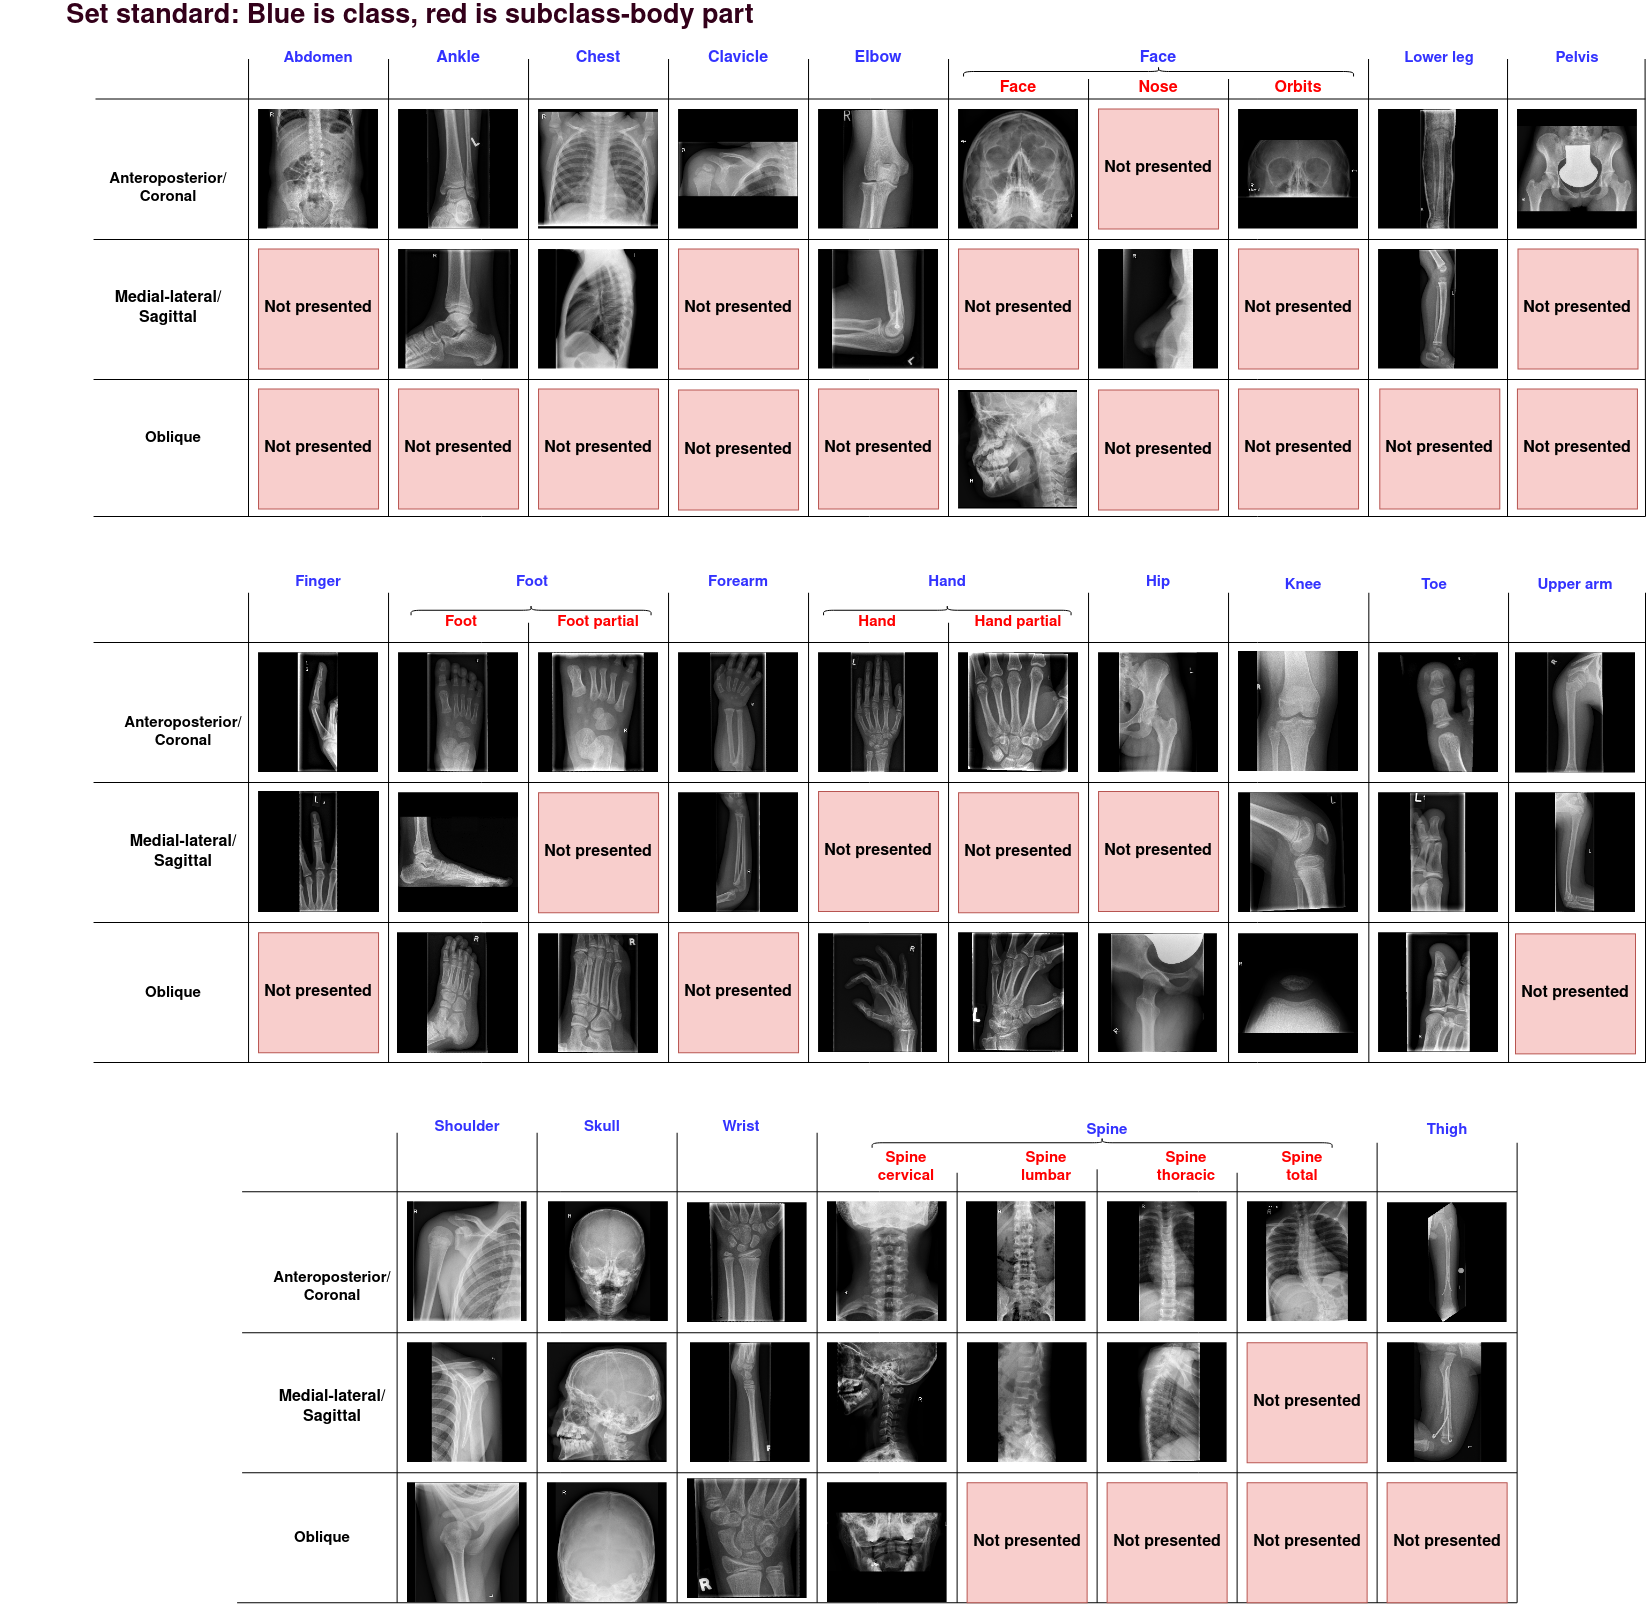

###  Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
import math
from scipy import ndimage
from sklearn.metrics import mean_squared_error 
import cv2
import tensorflow as tf
keras = tf.keras

# Enable CPU
tf.config.set_visible_devices([], 'GPU')
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

# Stage I: Preprocessing and image alignment

In [ ]:
def PCA_align(raw_image):

    #Adding border
    bordersize = 100
    border_image=cv2.copyMakeBorder(raw_image, top=bordersize, bottom=bordersize, left=bordersize, 
                                    right=bordersize, borderType= cv2.BORDER_CONSTANT, value=[0,0,0] )
    
    #BW image
    ret,bw_image = cv2.threshold(border_image, 1, 255, cv2.THRESH_BINARY)

    #Morphological closing
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    dilate_image = cv2.morphologyEx(bw_image, cv2.MORPH_CLOSE, kernel1, iterations=25)
    
    
    #Row filling with white dots
    for i,row in enumerate(dilate_image):
        if 255 in row.tolist():
            first = row.tolist().index(255)
            last = len(row.tolist()) - 1 - row.tolist()[::-1].index(255)
            dilate_image[i, first:last] = 255

    #Colum filling with white dots:
    for i,row in enumerate(dilate_image.T):
        if 255 in row.tolist():
            first = row.tolist().index(255)
            last = len(row.tolist()) - 1 - row.tolist()[::-1].index(255)
            dilate_image[first:last, i] = 255
    
    # Estimate the image shape
    # Get contours
    contours, hiearachy = cv2.findContours(dilate_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    
    # Find minimum bounding box
    if (len(contours) == 0):
        return (img)

    im = np.zeros_like(dilate_image)
    img = cv2.drawContours(im, contours, -1, (255,255,255), 1)

    rect = cv2.minAreaRect(contours[0])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    img = cv2.drawContours(img,[box],0,(255,255,255),2)

    dilate_image = img.copy()

    #Row filling with white dots
    for i,row in enumerate(dilate_image):
        if 255 in row.tolist():
            first = row.tolist().index(255)
            last = len(row.tolist()) - 1 - row.tolist()[::-1].index(255)
            dilate_image[i, first:last] = 255

    #Colum filling with white dots:
    for i,row in enumerate(dilate_image.T):
        if 255 in row.tolist():
            first = row.tolist().index(255)
            last = len(row.tolist()) - 1 - row.tolist()[::-1].index(255)
            dilate_image[first:last, i] = 255
    
    
    #Get points and create data
    points = np.argwhere(dilate_image != 0)
    points = np.array(points)

    x = [i[1] for i in points]
    y = [-i[0] for i in points]


    data = list(zip(x, y))
    data = np.asarray(data)

    #Calculate PCA of the data
    mu = data.mean(axis=0)
    data = data - mu

    eigenvectors, eigenvalues, V = np.linalg.svd(data.T, full_matrices=False)
    projected_data = np.dot(data, eigenvectors)

    sigma = projected_data.std(axis=0).mean()
    x1,y1 = eigenvectors[0]

    #Calculate angle
    angle =np.arctan2(y1, x1) * 180 / np.pi;

    #Transform angle
    if angle < 0:
        transformed_angle = angle+180
    else:
        transformed_angle = angle
   
    # Add threshold for rotation, if angle of rotation is above treshold, whole angle will be used otherwise only half 
    flag = False
    rotate_threshold = 0
    flag = True
    h,w = raw_image.shape
    
    if w > h:
        if transformed_angle > 90:
            flag = True
            rotated_image = ndimage.rotate(border_image, 180-transformed_angle)
        else:
            flag = True
            rotated_image = ndimage.rotate(border_image, -transformed_angle)
    else:
        if transformed_angle > 90:    
            flag = True
            rotated_image = ndimage.rotate(border_image, -(transformed_angle-90))
        else:
            flag = True
            rotated_image = ndimage.rotate(border_image, 90-transformed_angle)
           

    if flag == False:
        rotated_image = border_image.copy()
        
    # Remove rows with no data
    sum_of_rows = np.sum(rotated_image,axis=1).tolist()
    indexes_of_rows = [i for i,n in enumerate(sum_of_rows) if n != 0]
    cleared_rows_image = rotated_image[indexes_of_rows,:]

    # Remove cols with no data
    sum_of_cols = np.sum(cleared_rows_image,axis=0).tolist()
    indexes_of_cols = [i for i,n in enumerate(sum_of_cols) if n != 0]

    # Output image
    output_image = cleared_rows_image[:,indexes_of_cols]
    
    # Returning output image
    return np.stack((output_image,)*3, axis=-1), transformed_angle



## Stage II: Scaling the image and calculating orientation label

In [ ]:
# Function that returns scaled image by adding black border
def scaleImage(image, scale = 299):
    # Get image height and width
    height, width, ch = image.shape
    
    # Get max from height and width
    max_size = max(height, width)
    
    # Calculate the ratio
    if max_size < scale:
        ratio = max_size / float(scale)
    else:
        ratio = scale / float(max_size)
    
    # Calculate new dimensions
    new_height = int(height * ratio)
    new_width = int(width * ratio)

    # Fix floating point
    if abs(new_height - scale) <= 1:
        new_height = scale
    
    if abs(new_width - scale) <= 1:
        new_width = scale
    
    # Resize image
    resized_image = cv2.resize(image, (new_width, new_height), interpolation = cv2.INTER_LANCZOS4)
    
    # Calculate padding amount
    height_difference = scale - new_height
    width_difference = scale - new_width
    
    height_padding_top = math.floor(height_difference / 2)
    height_padding_bottom = height_difference - height_padding_top
    
    width_padding_left = math.floor(width_difference / 2)
    width_padding_right = width_difference - width_padding_left
    
    # Add padding
    output_image = cv2.copyMakeBorder(resized_image, height_padding_top, height_padding_bottom,
                                      width_padding_left, width_padding_right,
                                      cv2.BORDER_CONSTANT, value=(0, 0, 0))
    
    return (output_image)

# Calculate the orientation label:
def get_label(image, model):
    # Generate rotation labels dictionary
    class_label = {0:'N', 1:'S', 2:'E', 3:'W'}

    # Preprocess image for VGG16
    scaled_image = scaleImage(align_image, scale = 224)

    image = tf.cast(scaled_image, dtype = tf.float32) #Necessity otherwise really bad practice
    image = image / 255.
    image = np.expand_dims(image, axis=0)
    
    # Get prediction
    prediction = model.predict([image])
    label = class_label[np.argmax(prediction)]
    return label

# Main script

In [ ]:
# Load VGG network
model = keras.models.load_model("VGG16BestModel.h5", compile = False)   

In [ ]:
# Load image
input_image = cv2.imread('../DataExamples/wrist/3.png', 0)


# Align image
align_image, angle = PCA_align(input_image)

label = get_label(align_image, model)

print("Predicted label for aligned image is:{}".format(label))

##****** OUR SET STANDARD ******##
# Orient image according to our set standard
output_image = align_image
if label == 'S':
    output_image = ndimage.rotate(align_image, 180)

if label == 'E':    
    output_image = ndimage.rotate(align_image, 90)
    

if label == 'W':
    output_image = ndimage.rotate(align_image, -90)
##******************************##
    
# Display images
%matplotlib inline
plt.figure('Input image')
plt.imshow(input_image, cmap = 'gray')
plt.title("Input image")

plt.figure("Aligned image by PCA")
plt.imshow(align_image, cmap= 'gray')
plt.title("Aligned image by PCA.")

plt.figure("Final image")
plt.imshow(output_image, cmap= 'gray')
plt.title("Final North oriented image (predicted label = {})".format(label))
plt.show()
